# Training a neural network with McSnow autoconversion output

This script applies a DNN to the regression problem to find Phi_au(tau) of Seifert and Beheng (2001)

Here it is tested with a Log transform of data and predictors is helpful. In short: it is!

Much of this follows the basic regression example from the Tensorflow tutorial

https://www.tensorflow.org/tutorials/keras/regression


### Load Tensorflow and other useful modules

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

import pathlib

import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

print(tf.__version__)

2.1.0


### Load data from netcdf

In [2]:
import numpy as np
import xarray as xr

In [3]:
mdir='/Users/axel/DWD/GITLAB/mcsnow/'
edir='experiments/'

# small dataset with selected parameter range, e.g. starting at 11 mu radius and nu=0,1,2, and only 2 independent realizations
fname1=mdir+edir+'autocon_train_small.nc'
fname2=mdir+edir+'autocon_test_small.nc'

ds1 = xr.open_dataset(fname1)
ds2 = xr.open_dataset(fname2)
print('ds1: ', ds1)

ds1:  <xarray.Dataset>
Dimensions:     (i: 5, ii: 5, j: 5, jj: 5, k: 3, kk: 3, n: 2, nn: 2, nt: 4000)
Coordinates:
  * n           (n) int32 0 1
  * i           (i) int32 400 600 800 1000 2000
  * j           (j) int32 11 12 13 14 15
  * k           (k) int32 0 1 2
Dimensions without coordinates: ii, jj, kk, nn, nt
Data variables:
    time        (n, i, j, k, nt) float32 ...
    tau         (n, i, j, k, nt) float32 ...
    Lc          (n, i, j, k, nt) float32 ...
    Nc          (n, i, j, k, nt) float32 ...
    Zc          (n, i, j, k, nt) float32 ...
    Lr          (n, i, j, k, nt) float32 ...
    Nr          (n, i, j, k, nt) float32 ...
    Zr          (n, i, j, k, nt) float32 ...
    nu          (n, i, j, k, nt) float32 ...
    mue         (n, i, j, k, nt) float64 ...
    nue         (n, i, j, k, nt) float64 ...
    auto_num    (n, i, j, k, nt) float32 ...
    auto_mass   (n, i, j, k, nt) float32 ...
    accr_num    (n, i, j, k, nt) float32 ...
    accr_mass   (n, i, j, k, nt) floa

# Prepare data for training

In [4]:
def read_and_prepare_data(fname,auto_sml):
    # Read some data, we just want simple nparrays. Hence the .values
    tau  = xr.open_dataset(fname).tau.values
    auto = xr.open_dataset(fname).auto_mass.values
    Lc   = xr.open_dataset(fname).Lc.values
    Lr   = xr.open_dataset(fname).Lr.values
    Nc   = xr.open_dataset(fname).Nc.values
    nu   = xr.open_dataset(fname).nu.values
    # some numerical lower bounds
    L_min = 1e-15
    N_min = 1e-15
    tau_min  = 1e-15
    auto_min = 1e-15
    # introduce small but non-zero value for autoconversion into the dataset
    # (this can maybe called "data augmentation", because in that way we keep more data by adding artificial "labels")
    if auto_sml > 0:
        if (auto_sml < 1):
            # small but constant value
            auto = np.where( (Lc > 1e-5) & (auto < auto_sml) & (tau < 0.1),auto_sml,auto)
        else:
            # use autoconversion based on Long kernel. This gives our augmented data the proper scaling
            kcc = 9.44e9     # Long kernel in m3 kg-2 s-1 
            xstar = 2.6e-10    # xstar in kg
            auLg = kcc/(20*xstar) * (nu+2.0)*(nu+4.0)/(nu+1.0)**2 * Lc**2 * (Lc/(Nc+N_min))**2
            auto = np.where( (Lc > 1e-5) & (auto < auLg) & (tau < 0.1),auLg,auto)
    # take out L**2 dependency
    autoL2 = auto * np.power(Lc,-2)
    # transform everything except nu in log space
    Xc = np.log(Lc/Nc, where=Nc>N_min)
    Nc = np.log(Nc, where=Nc>N_min)
    Lc = np.log(Lc, where=Lc>L_min)
    Lr = np.log(Lr, where=Lr>L_min)
    tau  = np.log(tau, where=tau>tau_min, out=np.nan*tau)    
    auto = np.log(auto, where=auto>auto_min, out=np.nan*auto)
    autoL2 = np.log(autoL2, where=autoL2>auto_min, out=np.nan*autoL2)
    # put everything in a pandas dataframe
    dataset = pd.DataFrame(np.array( [ auto.ravel(), autoL2.ravel(), Lc.ravel(), Xc.ravel(), Lr.ravel(), tau.ravel(), nu.ravel() ]))
    dataset = dataset.T
    dataset.columns = ['auto','autoL2','Lc','Xc','Lr','tau','nu'] 
    # remove missing values immediately
    dataset = dataset.dropna()
    return dataset

In [5]:
# introduce small but non-zero value for autoconversion if AUsml > 0, Long-Value for AUsml=1#
#AUsml=1e-10
AUsml=0

dataset_train = read_and_prepare_data(fname1,AUsml)

/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in greater
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in greater
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in greater
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in greater
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in greater


In [6]:
dataset_test = read_and_prepare_data(fname2,0)

/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in greater
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in greater
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in greater
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in greater
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in greater


### Inspect the data

In [7]:
dataset_train.head()

auto     autoL2        Lc         Xc         Lr        tau   nu
13 -31.955315 -16.297400 -7.828958 -25.904518 -28.794966 -20.966007  0.0
14 -32.915257 -17.257339 -7.828958 -25.904099 -28.483360 -20.654404  0.0
15 -33.319088 -17.661173 -7.828958 -25.903637 -28.317514 -20.488556  0.0
16 -33.639503 -17.981586 -7.828958 -25.903223 -28.202843 -20.373884  0.0
17 -32.114964 -16.457048 -7.828958 -25.902739 -27.843679 -20.014721  0.0

In [8]:
dataset_test.head()

auto     autoL2        Lc         Xc         Lr        tau   nu
6  -34.323124 -19.111692 -7.605716 -25.907806 -31.215548 -23.609831  0.0
9  -34.108078 -18.896646 -7.605716 -25.906372 -30.268938 -22.663221  0.0
10 -34.394253 -19.182819 -7.605716 -25.905951 -29.971655 -22.365938  0.0
11 -33.336956 -18.125526 -7.605716 -25.905224 -29.424713 -21.818996  0.0
12 -30.451426 -15.239994 -7.605716 -25.904516 -27.272236 -19.666519  0.0

In [9]:
dataset_train.describe()

auto        autoL2            Lc            Xc            Lr  \
count  22464.000000  22464.000000  22464.000000  22464.000000  22464.000000   
mean     -20.998224     -4.772966     -8.112614    -25.519350    -11.661000   
std        3.725131      3.635280      1.300741      0.390998      4.996461   
min      -34.534893    -22.034744    -14.480739    -28.023979    -31.411810   
25%      -23.006994     -5.862841     -8.512681    -25.836073    -13.924418   
50%      -20.143305     -3.703865     -7.826228    -25.570807     -9.931336   
75%      -18.274826     -2.423589     -7.310647    -25.175462     -7.902456   
max      -13.800474      2.879898     -6.216034    -24.881920     -6.217121   

                tau            nu  
count  22464.000000  22464.000000  
mean      -4.336912      1.071181  
std        4.959246      0.807447  
min      -25.195736      0.000000  
25%       -6.543722      0.000000  
50%       -2.562852      1.000000  
75%       -0.395703      2.000000  
max       -0.001001      2.000000

In [10]:
dataset_test.describe()

auto       autoL2           Lc           Xc           Lr  \
count  8674.000000  8674.000000  8674.000000  8674.000000  8674.000000   
mean    -20.852304    -4.724188    -8.064062   -25.528807   -11.496886   
std       3.727293     3.604077     1.332807     0.399665     5.003183   
min     -34.528233   -21.315565   -14.469239   -27.925518   -31.462635   
25%     -22.912470    -5.715804    -8.515253   -25.839526   -13.729973   
50%     -19.877004    -3.639014    -7.605885   -25.572824    -9.696171   
75%     -18.100531    -2.423838    -7.266322   -25.178908    -7.696390   
max     -14.539376     1.993218    -6.503711   -24.882051    -6.504800   

               tau           nu  
count  8674.000000  8674.000000  
mean     -4.275846     1.067674  
std       4.975593     0.808918  
min     -24.799448     0.000000  
25%      -6.469460     0.000000  
50%      -2.444034     1.000000  
75%      -0.335903     2.000000  
max      -0.001042     2.000000

### Further reduce data to relevant parameter range for autoconversion

In [11]:
def reduce_data(dataset):
    idx = dataset[ dataset['tau'] > np.log(0.85) ].index
    dataset.drop(idx,inplace=True)
    idx = dataset[ dataset['Lc'] < np.log(0.02e-3) ].index
    dataset.drop(idx,inplace=True)   
    return dataset

In [12]:
dataset_test  = reduce_data(dataset_test)
dataset_train = reduce_data(dataset_train)

In [13]:
dataset_train.describe()

auto        autoL2            Lc            Xc            Lr  \
count  18647.000000  18647.000000  18647.000000  18647.000000  18647.000000   
mean     -20.430902     -5.165725     -7.632645    -25.456949    -12.562608   
std        3.679460      3.782158      0.659249      0.330802      5.024043   
min      -34.534893    -22.034744     -9.724918    -26.212313    -31.411810   
25%      -21.806603     -6.396546     -7.889613    -25.819818    -14.952552   
50%      -19.486141     -3.958683     -7.612981    -25.454456    -11.055310   
75%      -17.970150     -2.610244     -7.147993    -25.152584     -8.630443   
max      -13.800474      0.308441     -6.216034    -24.881920     -6.379271   

                tau            nu  
count  18647.000000  18647.000000  
mean      -5.212305      1.099104  
std        5.011799      0.803894  
min      -25.195736      0.000000  
25%       -7.579636      0.000000  
50%       -3.683315      1.000000  
75%       -1.235789      2.000000  
max       -0.162659      2.000000

In [14]:
dataset_test.describe()

auto       autoL2           Lc           Xc           Lr  \
count  7066.000000  7066.000000  7066.000000  7066.000000  7066.000000   
mean    -20.176025    -5.123621    -7.526208   -25.458292   -12.477570   
std       3.622492     3.787110     0.597939     0.331869     5.050320   
min     -34.528233   -21.315565    -9.498125   -26.213203   -31.462635   
25%     -21.366123    -6.326690    -7.709166   -25.821090   -14.889015   
50%     -19.154728    -3.894054    -7.602413   -25.468202   -10.949398   
75%     -17.798678    -2.620314    -7.171662   -25.152577    -8.498062   
max     -14.539376     0.126432    -6.503711   -24.882051    -6.667369   

               tau           nu  
count  7066.000000  7066.000000  
mean     -5.235489     1.100057  
std       5.042048     0.803946  
min     -24.799448     0.000000  
25%      -7.638224     0.000000  
50%      -3.690922     1.000000  
75%      -1.231778     2.000000  
max      -0.162936     2.000000

### Pairplot

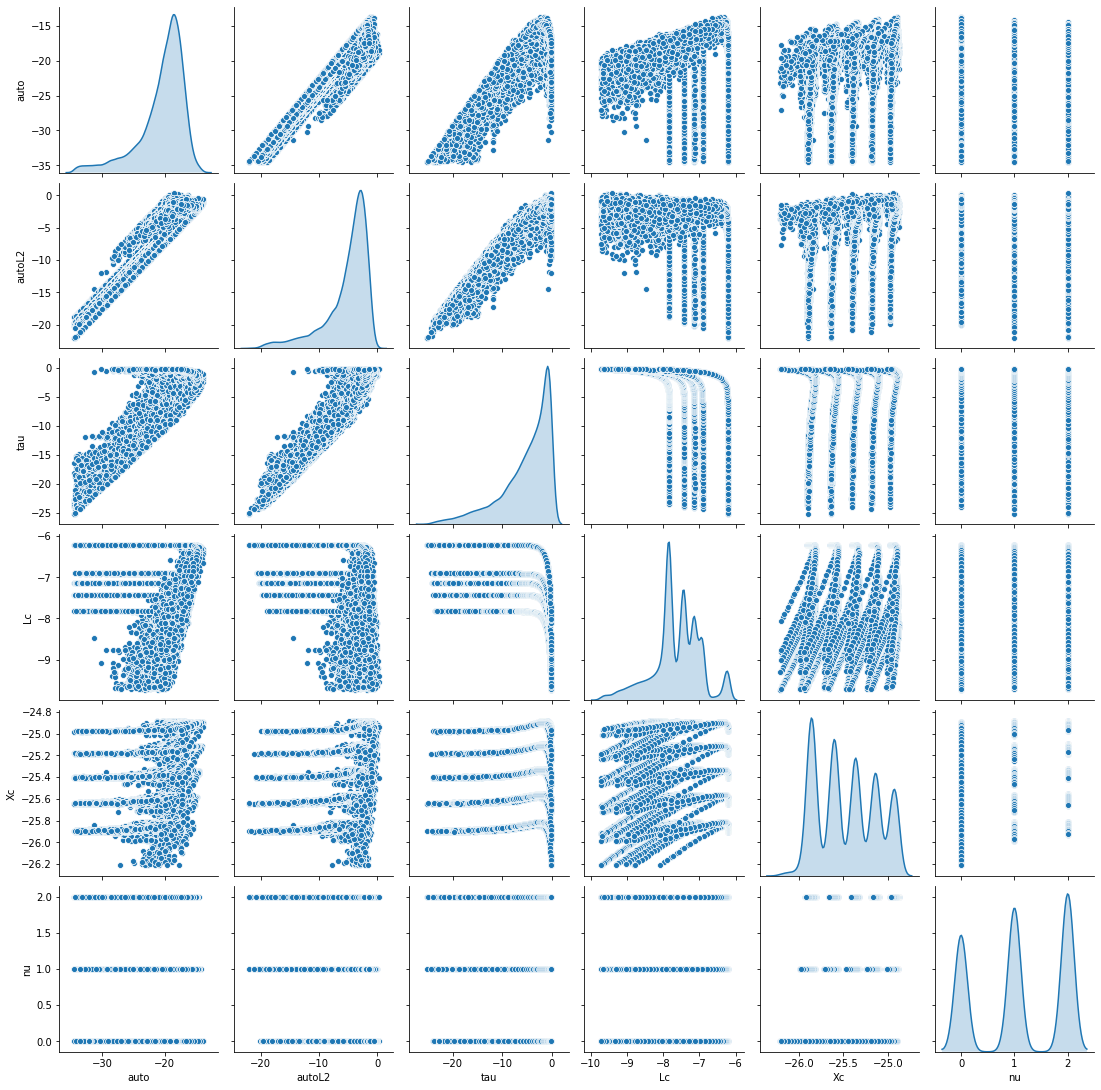

In [15]:
sns.pairplot(dataset_train[["auto","autoL2","tau","Lc","Xc",'nu']], diag_kind="kde")

## Separate in different dataset with selected sets of predictors

In [16]:
train_dataset0 = dataset_train.copy()
train_dataset1 = dataset_train.copy()
train_dataset2 = dataset_train.copy()
train_dataset3 = dataset_train.copy()
train_dataset4 = dataset_train.copy()

In [17]:
test_dataset0 = dataset_test.copy()
test_dataset1 = dataset_test.copy()
test_dataset2 = dataset_test.copy()
test_dataset3 = dataset_test.copy()
test_dataset4 = dataset_test.copy()

In [18]:
train_dataset0 = train_dataset0.drop(['autoL2','Lr','tau','nu'], axis=1)
train_dataset1 = train_dataset1.drop(['autoL2','Lr','tau'], axis=1)
train_dataset2 = train_dataset2.drop(['autoL2','tau'], axis=1)
train_dataset3 = train_dataset3.drop(['autoL2','Lr'], axis=1)
train_dataset4 = train_dataset4.drop(['auto','Lc','Lr'], axis=1)

In [19]:
test_dataset0 = test_dataset0.drop(['autoL2','Lr','tau','nu'], axis=1)
test_dataset1 = test_dataset1.drop(['autoL2','Lr','tau'], axis=1)
test_dataset2 = test_dataset2.drop(['autoL2','tau'], axis=1)
test_dataset3 = test_dataset3.drop(['autoL2','Lr'], axis=1)
test_dataset4 = test_dataset4.drop(['auto','Lc','Lr'], axis=1)

In [20]:
train_stats0 = train_dataset0.describe()
train_stats0.pop("auto")
train_stats0 = train_stats0.transpose()
train_stats0

count       mean       std        min        25%        50%        75%  \
Lc  18647.0  -7.632645  0.659249  -9.724918  -7.889613  -7.612981  -7.147993   
Xc  18647.0 -25.456949  0.330802 -26.212313 -25.819818 -25.454456 -25.152584   

          max  
Lc  -6.216034  
Xc -24.881920

In [21]:
train_stats1 = train_dataset1.describe()
train_stats1.pop("auto")
train_stats1 = train_stats1.transpose()
train_stats1

count       mean       std        min        25%        50%        75%  \
Lc  18647.0  -7.632645  0.659249  -9.724918  -7.889613  -7.612981  -7.147993   
Xc  18647.0 -25.456949  0.330802 -26.212313 -25.819818 -25.454456 -25.152584   
nu  18647.0   1.099104  0.803894   0.000000   0.000000   1.000000   2.000000   

          max  
Lc  -6.216034  
Xc -24.881920  
nu   2.000000

In [22]:
train_stats2 = train_dataset2.describe()
train_stats2.pop("auto")
train_stats2 = train_stats2.transpose()
train_stats2

count       mean       std        min        25%        50%        75%  \
Lc  18647.0  -7.632645  0.659249  -9.724918  -7.889613  -7.612981  -7.147993   
Xc  18647.0 -25.456949  0.330802 -26.212313 -25.819818 -25.454456 -25.152584   
Lr  18647.0 -12.562608  5.024043 -31.411810 -14.952552 -11.055310  -8.630443   
nu  18647.0   1.099104  0.803894   0.000000   0.000000   1.000000   2.000000   

          max  
Lc  -6.216034  
Xc -24.881920  
Lr  -6.379271  
nu   2.000000

In [23]:
train_stats3 = train_dataset3.describe()
train_stats3.pop("auto")
train_stats3 = train_stats3.transpose()
train_stats3

count       mean       std        min        25%        50%        75%  \
Lc   18647.0  -7.632645  0.659249  -9.724918  -7.889613  -7.612981  -7.147993   
Xc   18647.0 -25.456949  0.330802 -26.212313 -25.819818 -25.454456 -25.152584   
tau  18647.0  -5.212305  5.011799 -25.195736  -7.579636  -3.683315  -1.235789   
nu   18647.0   1.099104  0.803894   0.000000   0.000000   1.000000   2.000000   

           max  
Lc   -6.216034  
Xc  -24.881920  
tau  -0.162659  
nu    2.000000

In [24]:
train_stats4 = train_dataset4.describe()
train_stats4.pop("autoL2")
train_stats4 = train_stats4.transpose()
train_stats4

count       mean       std        min        25%        50%        75%  \
Xc   18647.0 -25.456949  0.330802 -26.212313 -25.819818 -25.454456 -25.152584   
tau  18647.0  -5.212305  5.011799 -25.195736  -7.579636  -3.683315  -1.235789   
nu   18647.0   1.099104  0.803894   0.000000   0.000000   1.000000   2.000000   

           max  
Xc  -24.881920  
tau  -0.162659  
nu    2.000000

### Split features from labels

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [25]:
train_labels0 = train_dataset0.pop('auto')
train_labels1 = train_dataset1.pop('auto')
train_labels2 = train_dataset2.pop('auto')
train_labels3 = train_dataset3.pop('auto')
train_labels4 = train_dataset4.pop('autoL2')

test_labels0  = test_dataset0.pop('auto')
test_labels1  = test_dataset1.pop('auto')
test_labels2  = test_dataset2.pop('auto')
test_labels3  = test_dataset3.pop('auto')
test_labels4  = test_dataset4.pop('autoL2')

### Normalize the data

In [26]:
def norm(x,stats):
  return (x - stats['mean']) / stats['std']

normed_train_data0 = norm(train_dataset0,train_stats0)
normed_train_data1 = norm(train_dataset1,train_stats1)
normed_train_data2 = norm(train_dataset2,train_stats2)
normed_train_data3 = norm(train_dataset3,train_stats3)
normed_train_data4 = norm(train_dataset4,train_stats4)

normed_test_data0 = norm(test_dataset0,train_stats0)
normed_test_data1 = norm(test_dataset1,train_stats1)
normed_test_data2 = norm(test_dataset2,train_stats2)
normed_test_data3 = norm(test_dataset3,train_stats3)
normed_test_data4 = norm(test_dataset4,train_stats4)

In [27]:
normed_train_stats0 = normed_train_data0.describe()
normed_train_stats0 = normed_train_stats0.transpose()
normed_train_stats0

count      mean       std       min       25%       50%       75%  \
Lc  18647.0  0.000124  1.000003 -3.173725 -0.389789  0.029828  0.735159   
Xc  18647.0  0.000142  0.999999 -2.283433 -1.096936  0.007536  0.920084   

         max  
Lc  2.148827  
Xc  1.738291

In [28]:
normed_train_stats1 = normed_train_data1.describe()
normed_train_stats1 = normed_train_stats1.transpose()
normed_train_stats1

count          mean       std       min       25%       50%       75%  \
Lc  18647.0  1.243925e-04  1.000003 -3.173725 -0.389789  0.029828  0.735159   
Xc  18647.0  1.417715e-04  0.999999 -2.283433 -1.096936  0.007536  0.920084   
nu  18647.0  1.135614e-08  1.000040 -1.367225 -1.367225 -0.123280  1.120665   

         max  
Lc  2.148827  
Xc  1.738291  
nu  1.120665

In [29]:
normed_train_stats2 = normed_train_data2.describe()
normed_train_stats2 = normed_train_stats2.transpose()
normed_train_stats2

count          mean       std       min       25%       50%       75%  \
Lc  18647.0  1.243925e-04  1.000003 -3.173725 -0.389789  0.029828  0.735159   
Xc  18647.0  1.417715e-04  0.999999 -2.283433 -1.096936  0.007536  0.920084   
Lr  18647.0  2.539994e-06  1.000000 -3.751799 -0.475701  0.300017  0.782669   
nu  18647.0  1.135614e-08  1.000040 -1.367225 -1.367225 -0.123280  1.120665   

         max  
Lc  2.148827  
Xc  1.738291  
Lr  1.230749  
nu  1.120665

In [30]:
normed_train_stats3 = normed_train_data3.describe()
normed_train_stats3 = normed_train_stats3.transpose()
normed_train_stats3

count          mean       std       min       25%       50%       75%  \
Lc   18647.0  1.243925e-04  1.000003 -3.173725 -0.389789  0.029828  0.735159   
Xc   18647.0  1.417715e-04  0.999999 -2.283433 -1.096936  0.007536  0.920084   
tau  18647.0  2.918792e-06  1.000001 -3.987277 -0.472352  0.305078  0.793431   
nu   18647.0  1.135614e-08  1.000040 -1.367225 -1.367225 -0.123280  1.120665   

          max  
Lc   2.148827  
Xc   1.738291  
tau  1.007551  
nu   1.120665

In [31]:
normed_train_stats4 = normed_train_data4.describe()
normed_train_stats4 = normed_train_stats4.transpose()
normed_train_stats4

count          mean       std       min       25%       50%       75%  \
Xc   18647.0  1.417715e-04  0.999999 -2.283433 -1.096936  0.007536  0.920084   
tau  18647.0  2.918792e-06  1.000001 -3.987277 -0.472352  0.305078  0.793431   
nu   18647.0  1.135614e-08  1.000040 -1.367225 -1.367225 -0.123280  1.120665   

          max  
Xc   1.738291  
tau  1.007551  
nu   1.120665

# The model

## Build the model

In [32]:

def build_model_tanh(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='tanh', input_shape=[ncol]),
    layers.Dense(16, activation='tanh'),
    layers.Dense(16, activation='tanh'),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# scaled exponential linear unit (Klambauer et al. 2015) with LeCun initialization
def build_model_selu(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='tanh', input_shape=[ncol]),
    layers.Dense(16, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(16, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Most common activation piecewise linear function, which should be use with He-initialization
def build_model_relu(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[ncol]),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Leaky ReLU with max(alpha*z,z), which helps to avoid dying neurons
def build_model_leaky_relu(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, input_shape=[ncol]),
    layers.Dense(16, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(16, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Parametric leaky ReLU with max(alpha*z,z), but alpha is now a trainable parameter
# This has a strongly increased risk of overfitting!
def build_model_param_relu(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, input_shape=[ncol]),
    layers.Dense(16, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(16, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[ncol]),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[ncol]),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_model(ncol,activation,learning_rate):
    if activation == "tanh":
        model = build_model_tanh(ncol,learning_rate)
    elif activation == "SELU":
        model = build_model_selu(ncol,learning_rate)
    elif activation == "ReLU":
        model = build_model_relu(ncol,learning_rate)
    elif activation == "ReLU_SGD":
        model = build_model_relu_SGD(ncol,learning_rate)
    elif activation == "ReLU_Adam":
        model = build_model_relu_Adam(ncol,learning_rate)
    elif activation == "LReLU":
        model = build_model_leaky_relu(ncol,learning_rate)
    elif activation == "PReLU":
        model = build_model_param_relu(ncol,learning_rate)
    else:
        print("Error: Wrong choice for activation")
    return model        

In [33]:

#activ = "PReLU"
#activ = "LReLU"
activ = "tanh"
#activ = "ReLU_SGD"
#activ = "ReLU_Adam"
#activ = "ReLU"

model = build_model(3,activ,1e-3)

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                64        
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 625
Trainable params: 625
Non-trainable params: 0
_________________________________________________________________


Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [35]:
example_batch  = normed_train_data4[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.46261653],
       [-0.46013618],
       [-0.4587409 ],
       [-0.4577456 ],
       [-0.45451188],
       [-0.4524128 ],
       [-0.4503581 ],
       [-0.44633526],
       [-0.43544596],
       [-0.4331782 ]], dtype=float32)

It seems to be working, if it produces a result of the expected shape and type and no NaN.

# Train the model

Use early stopping

In [36]:
# maximum number, but we use early stopping
EPOCHS = 100

# part of training data that is used for validation during training
VALSPLIT = 0.3

# learning rate
learn = 1e-3        # original value is 1e-3, but smaller might be better?

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# for collecting the histories
histories = {}

In [37]:
model0 = build_model(len(normed_train_data0.keys()),activ,learn)

early_history0 = model0.fit(normed_train_data0, train_labels0, 
                    epochs=EPOCHS, validation_split=VALSPLIT, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:221.1414,  mae:13.9785,  mse:221.1413,  val_loss:80.3984,  val_mae:8.2099,  val_mse:80.3984,  
....................................................................................................

Text(0, 0.5, 'MAE')

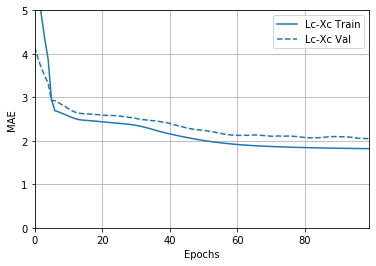

In [38]:
histories['Lc-Xc'] = early_history0

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0, 5])
plt.ylabel('MAE')

In [39]:
model1 = build_model(len(normed_train_data1.keys()),activ,learn)

early_history1 = model1.fit(normed_train_data1, train_labels1, 
                    epochs=EPOCHS, validation_split=VALSPLIT, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:232.2362,  mae:14.3945,  mse:232.2363,  val_loss:86.3776,  val_mae:8.5663,  val_mse:86.3776,  
.......................

Text(0, 0.5, 'MAE')

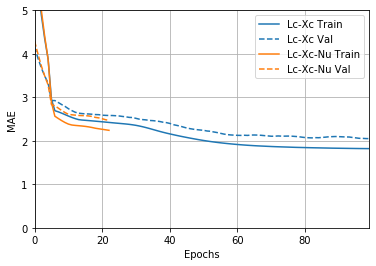

In [40]:
histories['Lc-xc-nu'] = early_history1

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0, 5])
plt.ylabel('MAE')

In [41]:
model2 = build_model(len(normed_train_data2.keys()),activ,learn)

early_history2 = model2.fit(normed_train_data2, train_labels2, 
                    epochs=EPOCHS, validation_split=VALSPLIT, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:231.9510,  mae:14.3487,  mse:231.9509,  val_loss:83.1750,  val_mae:8.3775,  val_mse:83.1750,  
..............................

Text(0, 0.5, 'MAE')

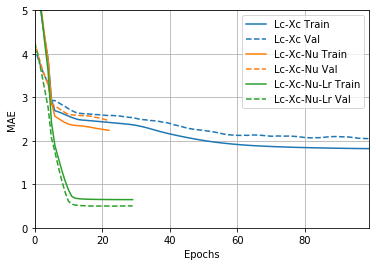

In [42]:
histories['Lc-xc-nu-Lr'] = early_history2

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0, 5])
plt.ylabel('MAE')

In [43]:
model3 = build_model(len(normed_train_data3.keys()),activ,learn)

early_history3 = model3.fit(normed_train_data3, train_labels3, 
                    epochs=EPOCHS, validation_split=VALSPLIT, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:205.3704,  mae:13.3289,  mse:205.3704,  val_loss:62.6405,  val_mae:7.0461,  val_mse:62.6405,  
..................................................

Text(0, 0.5, 'MAE')

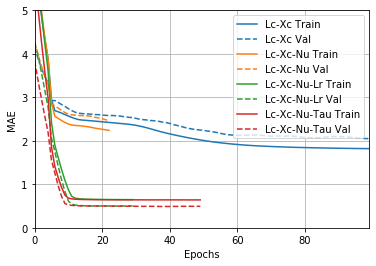

In [44]:
histories['Lc-xc-nu-tau'] = early_history3

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0, 5])
plt.ylabel('MAE')

In [45]:
model4 = build_model(len(normed_train_data4.keys()),activ,learn)

early_history4 = model4.fit(normed_train_data4, train_labels4, 
                    epochs=EPOCHS, validation_split=VALSPLIT, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:9.7941,  mae:2.0760,  mse:9.7941,  val_loss:3.6678,  val_mae:1.2027,  val_mse:3.6678,  
...................................

Text(0, 0.5, 'MAE of AU')

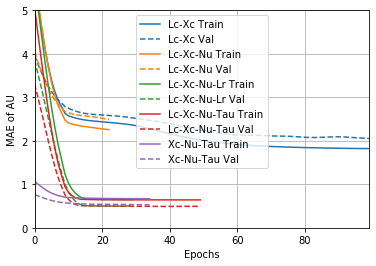

In [46]:
histories['xc-nu-tau'] = early_history4

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

plotter.plot(histories, metric = "mae")
plt.ylim([0, 5])
plt.ylabel('MAE of AU')

Text(0, 0.5, 'MSE of AU')

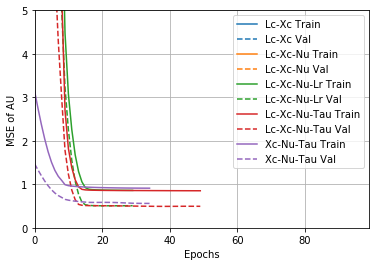

In [47]:
plotter.plot(histories, metric = "mse")
plt.ylim([0, 5])
plt.ylabel('MSE of AU')

In [48]:
loss0, mae0, mse0 = model0.evaluate(normed_test_data0, test_labels0, verbose=2)

print("Testing set for model 0, Mean Abs Error: {:10.5f}".format(mae0))

7066/7066 - 0s - loss: 11.9055 - mae: 2.2371 - mse: 11.9055
Testing set for model 0, Mean Abs Error:    2.23714


In [49]:
loss1, mae1, mse1 = model1.evaluate(normed_test_data1, test_labels1, verbose=2)

print("Testing set for model 1, Mean Abs Error: {:10.5f}".format(mae1))

7066/7066 - 0s - loss: 11.1279 - mae: 2.3121 - mse: 11.1279
Testing set for model 1, Mean Abs Error:    2.31210


In [50]:
loss2, mae2, mse2 = model2.evaluate(normed_test_data2, test_labels2, verbose=2)

print("Testing set for model 2, Mean Abs Error: {:10.5f}".format(mae2))

7066/7066 - 0s - loss: 0.6138 - mae: 0.5464 - mse: 0.6138
Testing set for model 2, Mean Abs Error:    0.54644


In [51]:
loss3, mae3, mse3 = model3.evaluate(normed_test_data3, test_labels3, verbose=2)

print("Testing set for model 3, Mean Abs Error: {:10.5f}".format(mae3))

7066/7066 - 0s - loss: 0.5959 - mae: 0.5354 - mse: 0.5959
Testing set for model 3, Mean Abs Error:    0.53540


In [52]:
loss4, mae4, mse4 = model4.evaluate(normed_test_data4, test_labels4, verbose=2)

print("Testing set for model 4, Mean Abs Error: {:10.5f}".format(mae4))

7066/7066 - 0s - loss: 0.6267 - mae: 0.5541 - mse: 0.6267
Testing set for model 4, Mean Abs Error:    0.55411


Note that model4 with 'xc-nu-tau' uses a different target dataset, different labels: auto/Lc**2. Hence, the metrics shown here are not comparable. This will be fixed in the next section.

# Make predictions

Finally, predict the fall velocity values using data in the testing set:

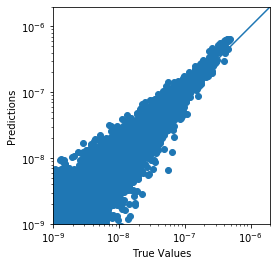

In [53]:
test_au0 = np.exp(test_labels0)
test_au1 = np.exp(test_labels1)
test_au2 = np.exp(test_labels2)
test_au3 = np.exp(test_labels3)

test_predict0 = np.exp(model0.predict(normed_test_data0).flatten())
test_predict1 = np.exp(model1.predict(normed_test_data1).flatten())
test_predict2 = np.exp(model2.predict(normed_test_data2).flatten())

amin, amax = 1e-9, 2e-6

a = plt.axes(aspect='equal')
plt.scatter(test_au2, test_predict2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

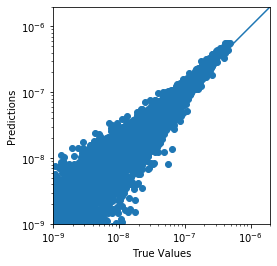

In [54]:
test_predict3 = np.exp(model3.predict(normed_test_data3).flatten())

a = plt.axes(aspect='equal')
plt.scatter(test_au3, test_predict3)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

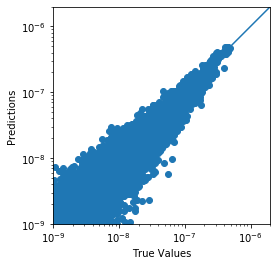

In [55]:
test_au4 = np.exp(test_labels4)

# re-scale this back to regular autoconversion
qc  = np.exp(np.array(test_dataset3.Lc))

test_predict4 = qc*qc * np.exp(model4.predict(normed_test_data4).flatten())
test_au4 = test_au4 * qc*qc

a = plt.axes(aspect='equal')
plt.scatter(test_au4, test_predict4)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

# Compare with SB2001 and KK2000

In [56]:
test_dataset3.describe()

Lc           Xc          tau           nu
count  7066.000000  7066.000000  7066.000000  7066.000000
mean     -7.526208   -25.458292    -5.235489     1.100057
std       0.597939     0.331869     5.042048     0.803946
min      -9.498125   -26.213203   -24.799448     0.000000
25%      -7.709166   -25.821090    -7.638224     0.000000
50%      -7.602413   -25.468202    -3.690922     1.000000
75%      -7.171662   -25.152577    -1.231778     2.000000
max      -6.503711   -24.882051    -0.162936     2.000000

In [57]:
qc  = np.exp(np.array(test_dataset3.Lc))
xc  = np.exp(np.array(test_dataset3.Xc))
nue = np.array(test_dataset3.nu)

tau2 = np.exp(np.array(test_dataset3.tau))

## SB2001 autoconversion rate, original and re-trained on current data

In [58]:
kcc = 9.44e9      # Long kernel in m3 kg-2 s-1 
xstar = 2.6e-10   # xstar in kg

au = kcc/(20*xstar) * (nue+2.0)*(nue+4.0)/(nue+1.0)**2 * qc**2 * xc**2

a1 = 600.
p1 = 0.68
taup = np.power(tau2,p1)
phi1 = a1 * taup * (1.0 - taup)**3

a2 = 954.
p2 = 0.773
taup = np.power(tau2,p2)
phi2 = a2 * taup * (1.0 - taup)**3

auSB1 = au * phi1
auSB2 = au * phi2


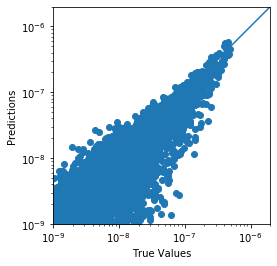

In [59]:
test_predict_sb = auSB2

amin, amax = 1e-9, 2e-6

a = plt.axes(aspect='equal')
plt.scatter(test_au3, test_predict_sb)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

## KK2000 autoconversion

In [60]:

nc = qc/xc * 1e-6  # Nc in CGS

auKK = 1350. * np.power(qc,2.47) * np.power(nc,-1.79)

## Power law regression 

from notebook 'McSnow_autocon_powerlaws'

In [61]:
fac = 7.540743e+13 
a = 2.786325 
b = -1.620419 
c = -0.808443 

nc = qc/xc

# AU = fac * Lc**a * Nc**b * nu**c
auPwr = fac * np.power(qc,a) * np.power(nc,b) * np.power(nue+1,c)  

In [62]:
np.mean(auPwr)

1.2416433e-08

In [63]:
np.mean(auKK)

9.221384e-09

## Final statistics 

In [64]:
au0 = test_predict0
au1 = test_predict1
au2 = test_predict2
au3 = test_predict3
au4 = test_predict4

auTruth = test_au3

In [65]:
np.max(auTruth)

4.848742491958546e-07

In [66]:
def mean_abs_error(au, auTrue):  
    return np.mean(np.abs(au - auTrue))

def mean_sqr_error(au, auTrue):    
    return np.sqrt(np.mean((au - auTrue)**2))                   

In [67]:
mae0 = mean_abs_error(au0,test_au0)
mae1 = mean_abs_error(au1,test_au1)
mae2 = mean_abs_error(au2,test_au2)
mae3 = mean_abs_error(au3,test_au3)
mae4 = mean_abs_error(au4,test_au4)
maeSB1 = mean_abs_error(auSB1,auTruth)
maeSB2 = mean_abs_error(auSB2,auTruth)
maeKK  = mean_abs_error(auKK,auTruth)
maePwr = mean_abs_error(auPwr,auTruth)

mse0 = mean_sqr_error(au0,test_au0)
mse1 = mean_sqr_error(au1,test_au1)
mse2 = mean_sqr_error(au2,test_au2)
mse3 = mean_sqr_error(au3,test_au3)
mse4 = mean_sqr_error(au4,test_au4)
mseSB1 = mean_sqr_error(auSB1,auTruth)
mseSB2 = mean_sqr_error(auSB2,auTruth)
mseKK  = mean_sqr_error(auKK,auTruth)
msePwr = mean_sqr_error(auPwr,auTruth)

mae = [ mae0, mae1, mae2, mae3, mae4, maeSB1, maeSB2, maeKK, maePwr ]
mse = [ mse0, mse1, mse2, mse3, mse4, mseSB1, mseSB2, mseKK, msePwr ]

In [68]:
mae

[1.4874396825348413e-08,
 1.5440004830225007e-08,
 5.392256863245848e-09,
 5.0109516536167575e-09,
 4.893126792637759e-09,
 9.236841513882155e-09,
 6.841116562128491e-09,
 1.624354517559823e-08,
 1.538469618367344e-08]

In [69]:
labels = list(histories.keys())
labels.append('SB2001')
labels.append('SB new')
labels.append('KK2000')
labels.append('Power')
labels

['Lc-Xc',
 'Lc-xc-nu',
 'Lc-xc-nu-Lr',
 'Lc-xc-nu-tau',
 'xc-nu-tau',
 'SB2001',
 'SB new',
 'KK2000',
 'Power']

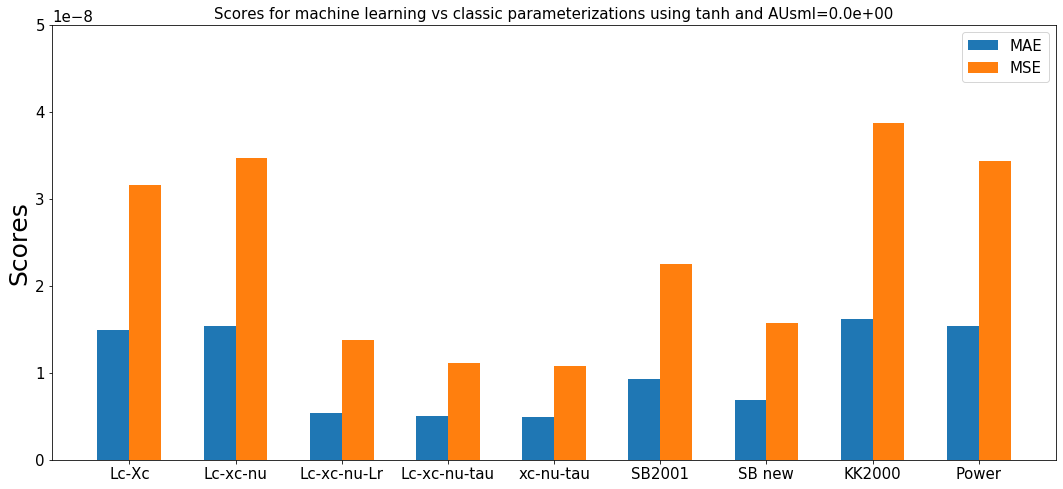

In [70]:
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mae, width, label='MAE')
rects2 = ax.bar(x + width/2, mse, width, label='MSE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores for machine learning vs classic parameterizations using '+activ+' and AUsml=%6.1e'%AUsml)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0,5e-8)
ax.legend()

#fig.tight_layout()

plt.show()

# Save models to file

In [71]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model

if AUsml == 1:
    AUsmlString = '_AuLong'
elif AUsml > 0:
    AUsmlString = '_AUsml%5.0e'%AUsml
else:
    AUsmlString = ''
    
model2.save('saved_model/autocon_LcXcNuLr_v5_'+activ+AUsmlString+'_16x16x16_small') 
model3.save('saved_model/autocon_LcXcNuTau_v5_'+activ+AUsmlString+'_16x16x16_small') 
model4.save('saved_model/autoL2_XcNuTau_v5_'+activ+AUsmlString+'_16x16x16_small') 

# save train_stats for normalization of input data in Pandas pickle format
#train_stats1.to_pickle('saved_model/autocon_LcXcNu_16x16x16_norm.pickle')
train_stats2.to_pickle('saved_model/autocon_LcXcNuLr_v5_'+activ+AUsmlString+'_16x16x16_small_norm.pickle')
train_stats3.to_pickle('saved_model/autocon_LcXcNuTau_v5_'+activ+AUsmlString+'_16x16x16_small_norm.pickle')
train_stats4.to_pickle('saved_model/autoL2_XcNuTau_v5_'+activ+AUsmlString+'_16x16x16_small_norm.pickle')


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_model/autocon_LcXcNuLr_v5_tanh_16x16x16_small/assets
INFO:tensorflow:Assets written to: saved_model/autocon_LcXcNuTau_v5_tanh_16x16x16_small/assets
INFO:tensorflow:Assets written to: saved_model/autoL2_XcNuTau_v5_tanh_16x16x16_small/assets


# Model on gridded data to visualize dependencies

In [72]:

qc1d = np.linspace(0.1,2.0,50) * 1e-3
#tau1d = np.logspace(1e-6,1.0,51)
tau1d = np.linspace(0,1.0,50)
nu1d = np.linspace(0,4,6)
rc1d = np.linspace(11,15,10) * 1e-6
#nc1d = np.linspace(np.nanmin(Nc),np.nanmax(Nc),20)

tau1d[0] = 1e-6

qc3d, tau3d, nu3d, rc3d = np.meshgrid(qc1d, tau1d, nu1d, rc1d)

xc3d = 4./3. * 3.14 * 1e3 * rc3d**3

In [73]:
nc3d = qc3d/xc3d
qr3d = qc3d * (1.0/tau3d - 1.0)

In [74]:
gdata = pd.DataFrame(np.array( [ np.log(qc3d.ravel()), np.log(xc3d.ravel()), np.log(qr3d.ravel()), np.log(tau3d.ravel()), nu3d.ravel() ]))
gdata = gdata.T
gdata.columns = ['Lc','Xc','Lr','tau','nu'] 

/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


In [75]:
gdata1 = gdata.copy()
gdata2 = gdata.copy()
gdata3 = gdata.copy()

In [76]:
gdata1 = gdata.drop(['Lr','tau'], axis=1)
gdata2 = gdata.drop("tau", axis=1)
gdata3 = gdata.drop("Lr", axis=1)

In [77]:
gdata3.head()

Lc         Xc        tau   nu
0 -9.21034 -25.913186 -13.815511  0.0
1 -9.21034 -25.794358 -13.815511  0.0
2 -9.21034 -25.680059 -13.815511  0.0
3 -9.21034 -25.569955 -13.815511  0.0
4 -9.21034 -25.463749 -13.815511  0.0

In [78]:
gdata3_stats = gdata3.describe()
gdata3_stats.transpose()

count       mean       std        min        25%        50%  \
Lc   150000.0  -7.070660  0.740840  -9.210340  -7.478143  -6.859136   
Xc   150000.0 -25.426613  0.296577 -25.913186 -25.680059 -25.412462   
tau  150000.0  -1.198979  2.001299 -13.815511  -1.406914  -0.693355   
nu   150000.0   2.000000  1.366265   0.000000   0.800000   2.000000   

           75%        max  
Lc   -6.479424  -6.214608  
Xc  -25.165984 -24.982721  
tau  -0.280902   0.000000  
nu    3.200000   4.000000

In [79]:
normed_gdata1 = norm(gdata1,train_stats1)
normed_gdata2 = norm(gdata2,train_stats2)
normed_gdata3 = norm(gdata3,train_stats3)

normed_gdata1_stats = normed_gdata1.describe()
normed_gdata1_stats.transpose()

count      mean       std       min       25%       50%       75%  \
Lc  150000.0  0.852464  1.123764 -2.393172  0.234361  1.173320  1.749296   
Xc  150000.0  0.091705  0.896541 -1.379185 -0.674451  0.134484  0.879576   
nu  150000.0  1.120665  1.699558 -1.367225 -0.372069  1.120665  2.613399   

         max  
Lc  2.150990  
Xc  1.433573  
nu  3.608555

In [80]:
auto1 = model1.predict(normed_gdata1).flatten()
auto2 = model2.predict(normed_gdata2).flatten()
auto3 = model3.predict(normed_gdata3).flatten()


In [81]:
auto3d_model1 = np.exp(np.reshape(auto1,qc3d.shape))
auto3d_model2 = np.exp(np.reshape(auto2,qc3d.shape))
auto3d_model3 = np.exp(np.reshape(auto3,qc3d.shape))

In [82]:
qc3d.shape

(50, 50, 6, 10)

In [83]:
au = kcc/(20*xstar) * (nu3d+2.0)*(nu3d+4.0)/(nu3d+1.0)**2 * qc3d**2 * xc3d**2
taup = np.power(tau3d,p2)
phi2 = a2 * taup * (1.0 - taup)**3

auSB = au * phi2

In [84]:
np.nanmean(auSB)

3.7857145093017184e-08

In [85]:
np.nanmean(auto3d_model3)

1.2675385e-07

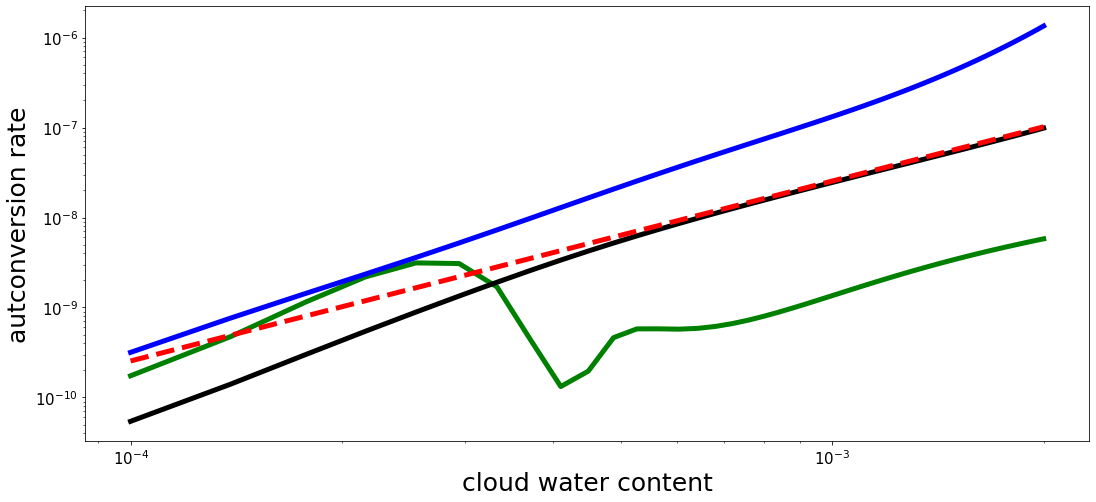

In [86]:
iqr = 3
inu = 2
inc = 3

plt.plot(qc3d[iqr,:,inu,inc], auto3d_model1[iqr,:,inu,inc], 'g-', linewidth=5)
plt.plot(qc3d[iqr,:,inu,inc], auto3d_model2[iqr,:,inu,inc], 'b-', linewidth=5)
plt.plot(qc3d[iqr,:,inu,inc], auto3d_model3[iqr,:,inu,inc], 'k-', linewidth=5)
plt.plot(qc3d[iqr,:,inu,inc], auSB[iqr,:,inu,inc], 'r--', linewidth=5)

plt.xlabel('cloud water content')
plt.ylabel('autconversion rate')

plt.yscale('log')
plt.xscale('log')
plt.show()

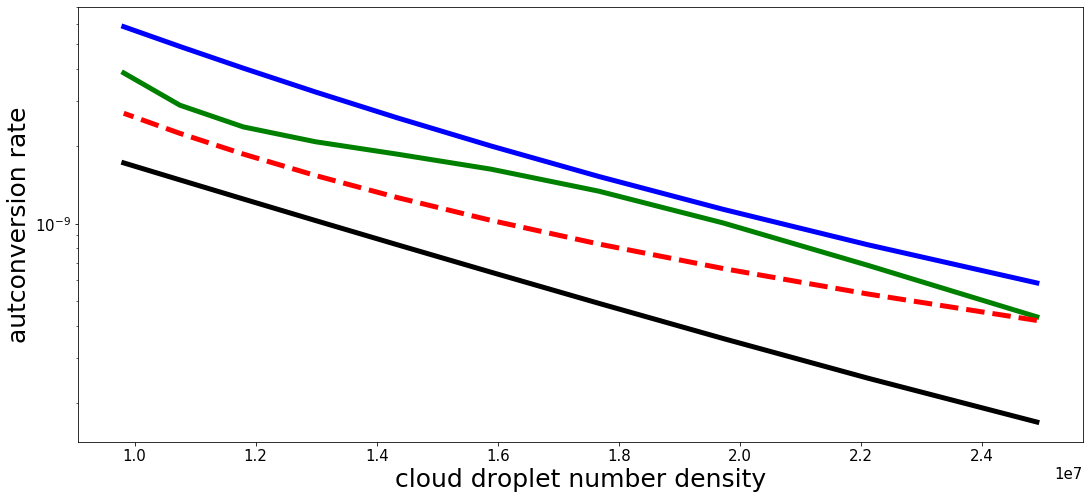

In [87]:
iqc = 1
iqr = 5
inu = 1

plt.plot(nc3d[iqr,iqc,inu,:], auto3d_model1[iqr,iqc,inu,:], 'g-', linewidth=5)
plt.plot(nc3d[iqr,iqc,inu,:], auto3d_model2[iqr,iqc,inu,:], 'b-', linewidth=5)
plt.plot(nc3d[iqr,iqc,inu,:], auto3d_model3[iqr,iqc,inu,:], 'k-', linewidth=5)
plt.plot(nc3d[iqr,iqc,inu,:], auSB[iqr,iqc,inu,:], 'r--', linewidth=5)

plt.xlabel('cloud droplet number density')
plt.ylabel('autconversion rate')

plt.yscale('log')
#plt.xscale('log')
plt.show()

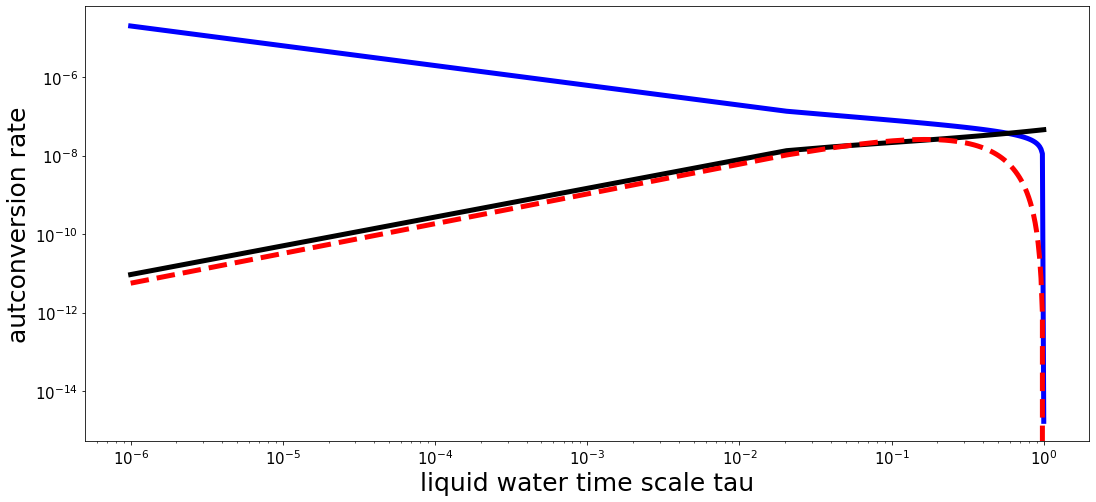

In [88]:
iqc = 20
inu = 2
inc = 3

#plt.plot(tau3d[:,iqc,inu,inc], auto3d_model2[:,iqc,inu,inc], 'g-', linewidth=5)
plt.plot(tau3d[:,iqc,inu,inc], auto3d_model2[:,iqc,inu,inc], 'b-', linewidth=5)
plt.plot(tau3d[:,iqc,inu,inc], auto3d_model3[:,iqc,inu,inc], 'k-', linewidth=5)
plt.plot(tau3d[:,iqc,inu,inc], auSB[:,iqc,inu,inc], 'r--', linewidth=5)

plt.xlabel('liquid water time scale tau')
plt.ylabel('autconversion rate')

plt.yscale('log')
plt.xscale('log')
plt.show()

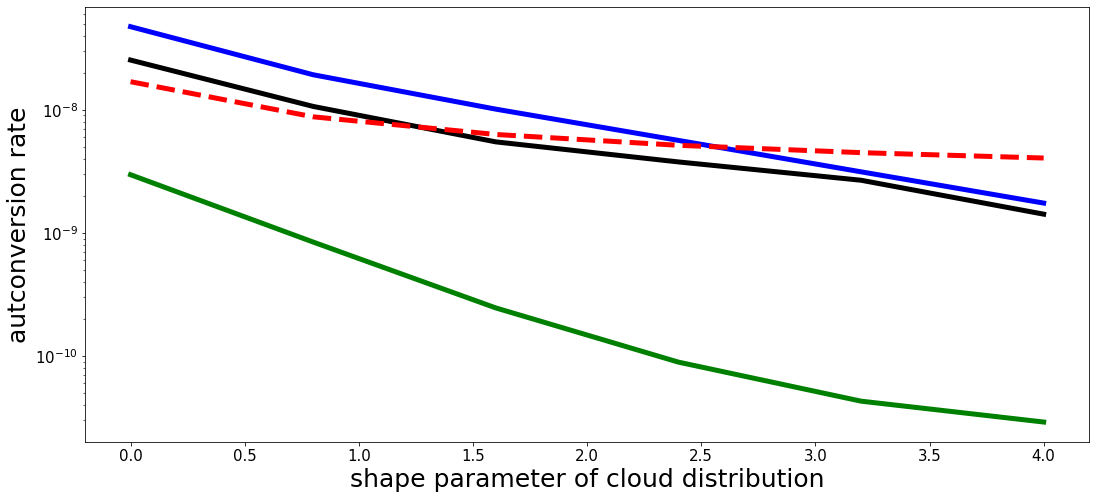

In [89]:
iqr = 10
iqc = 10
inc = 2

plt.plot(nu3d[iqr,iqc,:,inc], auto3d_model1[iqr,iqc,:,inc], 'g-', linewidth=5)
plt.plot(nu3d[iqr,iqc,:,inc], auto3d_model2[iqr,iqc,:,inc], 'b-', linewidth=5)
plt.plot(nu3d[iqr,iqc,:,inc], auto3d_model3[iqr,iqc,:,inc], 'k-', linewidth=5)
plt.plot(nu3d[iqr,iqc,:,inc], auSB[iqr,iqc,:,inc], 'r--', linewidth=5)

plt.xlabel('shape parameter of cloud distribution')
plt.ylabel('autconversion rate')

plt.yscale('log')
#plt.xscale('log')
plt.show()

In [90]:
def autocon(qc,xc,qr,nu):
    tau  = qr/(qc+qr)
    data = pd.DataFrame(np.array( [ np.log(qc.ravel()), np.log(xc.ravel()), np.log(tau.ravel()), nu.ravel() ]))
    data = data.T
    data.columns = [ 'Lc','Xc','tau','nu' ] 
    normed_data = norm(data,train_stats3)
    auto = model3.predict(normed_data).flatten()

    return np.exp(auto)

In [91]:

qc = np.array(1e-3)
xc = np.array(7.2e-12)
qr = np.array(1e-10)
nu = np.array(0.0)
print(autocon(qc,xc,qr,nu))

[3.2337878e-12]
